In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
import torch

/media/ssd/adversarial-manhole/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
carla_dataset = load_dataset("naufalso/carla_hd", cache_dir="./data/")
print(carla_dataset)

DatasetDict({
    train: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 1593
    })
    validation: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 531
    })
    test: Dataset({
        features: ['rgb', 'raw_depth', 'normal', 'semantic', 'camera_config', 'town', 'location_idx', 'camera_idx'],
        num_rows: 532
    })
})


In [3]:
filtered_columns_dataset = carla_dataset.select_columns(["rgb", "raw_depth", "camera_config"])
print(filtered_columns_dataset)

DatasetDict({
    train: Dataset({
        features: ['rgb', 'raw_depth', 'camera_config'],
        num_rows: 1593
    })
    validation: Dataset({
        features: ['rgb', 'raw_depth', 'camera_config'],
        num_rows: 531
    })
    test: Dataset({
        features: ['rgb', 'raw_depth', 'camera_config'],
        num_rows: 532
    })
})


In [4]:
def process_depth(depth_img_raw) -> np.ndarray:
    # Load the depth image
    depth_img_raw = np.asarray(depth_img_raw) / 255.0

    # Process carla depth image into correct depth values
    depth_img = (depth_img_raw[:, :, 0]) + (depth_img_raw[:, :, 1] * 256.0) + (depth_img_raw[:, :, 2] * 256.0 * 256.0)
    normalized_depth_img = depth_img / (256.0 * 256.0 * 256.0 - 1.0)

    return normalized_depth_img

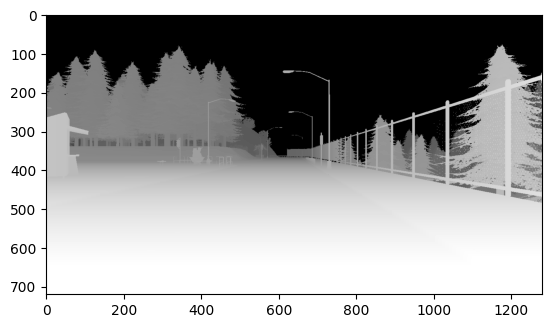

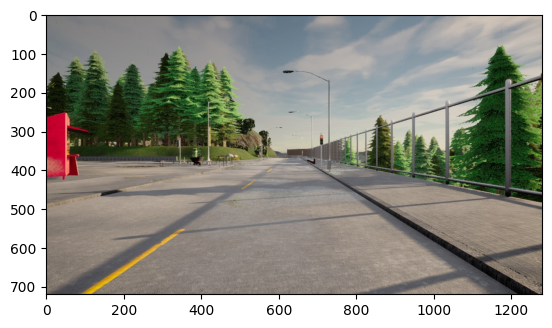

In [5]:
sample_depth_img = filtered_columns_dataset["train"][0]["raw_depth"]
processed_depth_img = process_depth(sample_depth_img)

vmax = np.percentile(-np.log(processed_depth_img), 90)

plt.imshow(-np.log(processed_depth_img), cmap='gray', vmax=vmax)
plt.show()

plt.imshow(filtered_columns_dataset["train"][0]['rgb'])
plt.show()

In [6]:
def depth_to_local_coordinates(normalized_depth_img, camera_config) -> np.ndarray:
    # Camera Intrinsic
    # (Intrinsic) K Matrix
    Cin = np.identity(3)
    Cin[0, 2] = camera_config["image_width"] / 2.0
    Cin[1, 2] = camera_config["image_height"] / 2.0
    Cin[0, 0] = Cin[1, 1] = camera_config["image_width"] / (
        2.0 * math.tan(camera_config["fov"] * math.pi / 360.0)
    )

    # # (Extrinsic) Transform Matrix [No need to use it]
    # Cex = np.array(camera_config["transform_matrix"])

    # 2D Pixel Coordinates [u, v, 1]
    pixel_length = camera_config["image_width"] * camera_config["image_height"]
    u_coord, v_coord = np.meshgrid(
        np.arange(camera_config["image_width"]),
        np.arange(camera_config["image_height"]),
    )
    u_coord_flat = np.reshape(u_coord, pixel_length)
    v_coord_flat = np.reshape(v_coord, pixel_length)
    normalized_depth_flat = np.reshape(normalized_depth_img, pixel_length)

    uv_matrix = np.stack([u_coord_flat, v_coord_flat, np.ones_like(u_coord_flat)])

    # 3D Local Coordinates = [x, y, z] (camera)
    local_3d_coordinate = np.dot(np.linalg.inv(Cin), uv_matrix)
    local_3d_coordinate *= normalized_depth_flat * 1000.0  # Convert to meters

    # New we must change from "standard" camera coordinate system (the same used by OpenCV) to Unreal coordinate system

    #    z             ^ z
    #   /              |
    #  +-------> x to  |
    #  |               | . x
    #  |               |/
    #  v y             +-------> y

    # Convert the camera coordinate to unreal coordinate: [x, y, z] -> [x, z, y]
    local_3d_coordinate_ue4 = np.array(
        [local_3d_coordinate[2], local_3d_coordinate[0], local_3d_coordinate[1] * -1.0]
    ).T

    # Reshape to image size
    local_3d_coordinate_ue4 = np.reshape(
        local_3d_coordinate_ue4,
        (camera_config["image_height"], camera_config["image_width"], 3),
    )

    # Centerize the local coordinates
    x_coord_min = np.min(local_3d_coordinate_ue4[:, :, 0])
    z_coord_min = np.min(local_3d_coordinate_ue4[:, :, 2])

    centerized_local_3d_coordinate_ue4 = local_3d_coordinate_ue4 - np.array(
        [x_coord_min, 0.0, z_coord_min]
    )

    # Convert from meters to centimeters
    centerized_local_3d_coordinate_ue4 *= 100.0

    # Convert to float32
    centerized_local_3d_coordinate_ue4 = centerized_local_3d_coordinate_ue4.astype(np.float32)

    return centerized_local_3d_coordinate_ue4

In [7]:
def mapped_texture_mask(
    surface_xyz,
    tex_size=1.0,
    tex_shift=[0.0, 0.0, 0.0],
):
    
    x_offset = tex_shift[0]
    y_offset = tex_shift[1]

    # Mask the centerized local coordinates given the texture size
    texture_mask = torch.where(
        (surface_xyz[0, ...] > x_offset)
        & (surface_xyz[0, ...] < x_offset + tex_size)
        & (surface_xyz[1, ...] > y_offset)
        & (surface_xyz[1, ...] < y_offset + tex_size),
        1.0,
        0.0,
    )

    return texture_mask


def depth_texture_mapping(
    texture,
    surface_xyz,
    tex_size=1.0,
    tex_shift=[0.0, 0.0, 0.0],
    texture_res=256,
):
    # Convert to channel last
    surface_xyz = surface_xyz.permute(1, 2, 0)
    # normal_mask = normal_mask.permute(1, 2, 0)
    texture_flat = texture.permute(1, 2, 0).view(-1, 3)
    max_uv_idx = texture_res**2 - 1

    # Get the UV coordinates by modulating the surface coordinates with the texture size
    surface_xyz_mod = (surface_xyz - tex_shift) % tex_size
    surface_xyz_mod = surface_xyz_mod / tex_size

    # Get the UV indices by multiplying the UV coordinates with the texture resolution
    uv_idx = surface_xyz_mod * texture_res
    uv_idx = torch.round(uv_idx).to(torch.int64)
    uv_idx = torch.clamp(uv_idx, 0, texture_res - 1)

    # Get the UV indices for each axis
    uv_idx_z = uv_idx[..., [0, 1]]

    # Invert the z uv indices
    uv_idx_z[..., 0] = texture_res - uv_idx_z[..., 0]

    # Get the UV indices for each axis flattened
    uv_idx_z_flat = (uv_idx_z[..., 0] * texture_res + uv_idx_z[..., 1]).clamp_max(
        max_uv_idx
    )

    # Get the rendered images for each axis
    rendered_img_z = texture_flat[uv_idx_z_flat.flatten(), :].reshape(
        surface_xyz_mod.shape
    )

    # Reverse the channel last to channel first
    rendered_img_z = rendered_img_z.permute(2, 0, 1)

    return rendered_img_z

In [8]:
centerized_local_3d_coordinate_ue4 = depth_to_local_coordinates(processed_depth_img, filtered_columns_dataset["train"][0]["camera_config"])
centerized_local_3d_coordinate_ue4.dtype

dtype('float32')

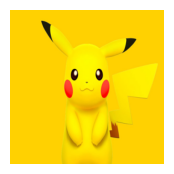

In [9]:
import requests
from PIL import Image

url = "https://cdn.vox-cdn.com/thumbor/PqAwdNpc7p-5GUCSMxQPehSU-ck=/0x0:1920x1200/1200x800/filters:focal(810x375:1116x681)/cdn.vox-cdn.com/uploads/chorus_image/image/72524797/pikachu_artwork.0.jpg"
pokemon_patch = np.array(
    Image.open(requests.get(url, stream=True).raw).resize((256, 256))
)
# Plotting the texture patch
plt.figure(figsize=(2, 2))
plt.imshow(pokemon_patch)
plt.axis("off")
plt.show()

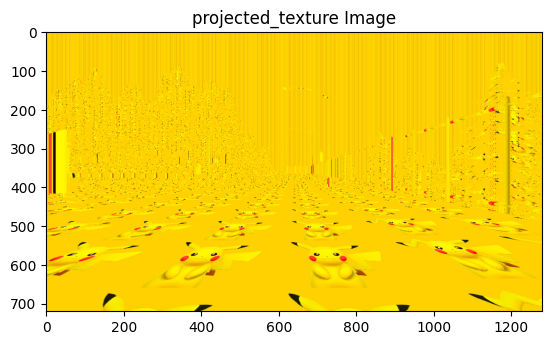

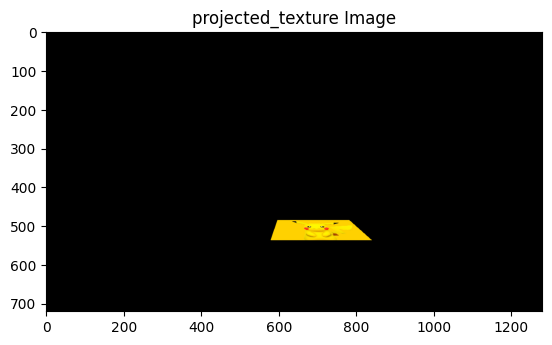

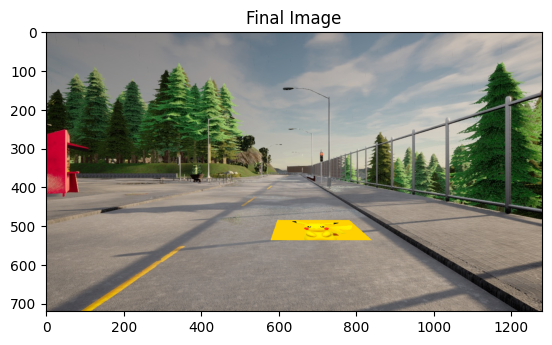

In [10]:
from torchvision.transforms import ToTensor

tex_size = 0.75

x_offset = 1.0
y_offset = 0.2 - (tex_size / 2.0)

tex_shift = torch.tensor([x_offset, y_offset, 0.0])
tex_size = torch.tensor(tex_size)

rgb_img_torch = ToTensor()(filtered_columns_dataset["train"][0]["rgb"])

surface_xyz = torch.tensor(centerized_local_3d_coordinate_ue4, dtype=torch.float32).permute(2, 0, 1)

texture_mask = mapped_texture_mask(
    surface_xyz,
    tex_size=tex_size,
    tex_shift=tex_shift,
)

# Project the texture
projected_texture = depth_texture_mapping(
    ToTensor()(pokemon_patch),
    surface_xyz,
    tex_size=tex_size,
    tex_shift=tex_shift,
)

# Plot the rendered image and mask
plt.figure()
plt.imshow((projected_texture).permute(1, 2, 0))
plt.title("projected_texture Image")
plt.show()


# Plot the rendered image and mask
plt.figure()
plt.imshow((projected_texture * texture_mask).permute(1, 2, 0))
plt.title("projected_texture Image")
plt.show()

# # Apply the texture mask to the rendered image
final_image = projected_texture * texture_mask + rgb_img_torch * (1.0 - texture_mask)

# # Plot the final image
plt.figure()
plt.imshow(final_image.permute(1, 2, 0))
plt.title("Final Image")
plt.show()

In [11]:
train_data = filtered_columns_dataset["train"]
val_data = filtered_columns_dataset["validation"]
test_data = filtered_columns_dataset["test"]

In [12]:
def process_surface_coordinates(raw_depth, camera_config):
    # Process the depth image
    processed_depth_img = process_depth(raw_depth)

    # Convert the depth image to local coordinates
    surface_xyz = depth_to_local_coordinates(processed_depth_img, camera_config)

    return surface_xyz

In [13]:
from torch.utils.data import DataLoader

In [14]:
train_data_iterable = train_data.to_iterable_dataset()
train_data_iterable = train_data_iterable.map(
    lambda example: {
        "local_surface_coors": ToTensor()(process_surface_coordinates(example["raw_depth"], example["camera_config"])),
        "rgb": ToTensor()(example["rgb"]),
    },
    remove_columns=["raw_depth", "camera_config"],
)

In [15]:
from torchvision import transforms

In [16]:
# Create color jitter transform for data augmentation
texture_augmentation = transforms.Compose([
    transforms.ColorJitter(brightness=0.5, contrast=0.25),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),

])

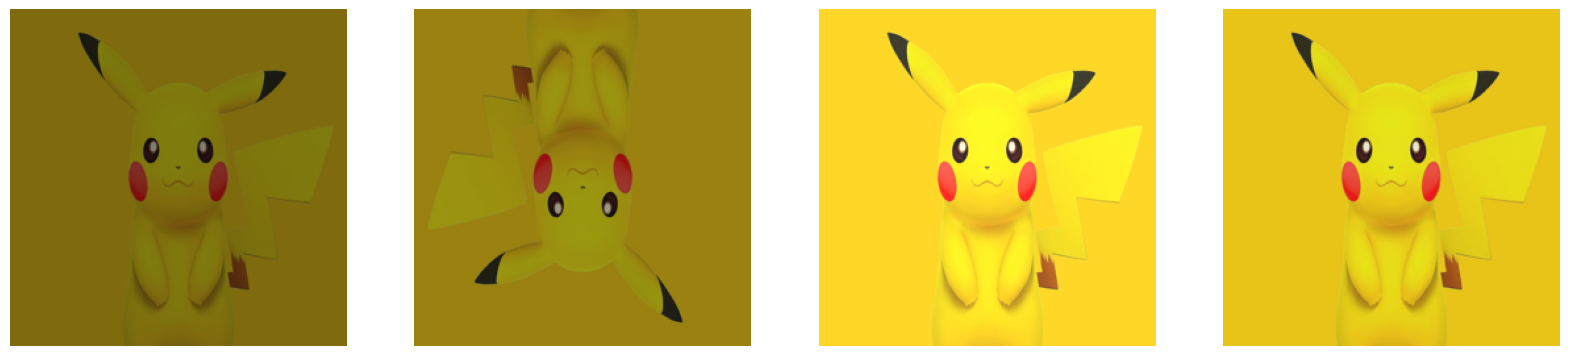

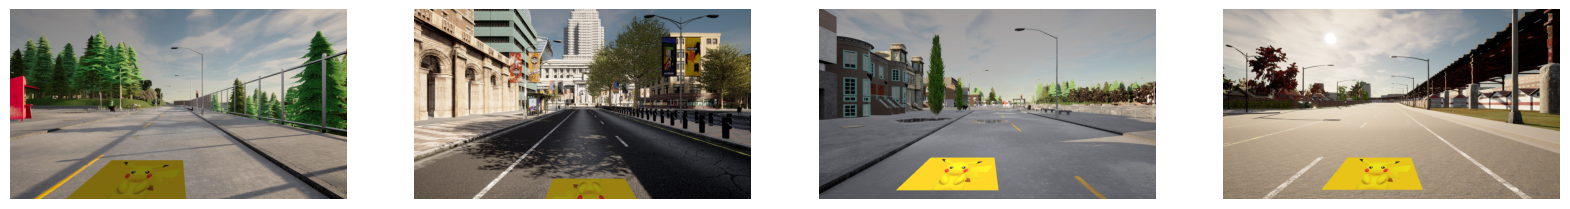

In [17]:
batch_size = 4
min_size, max_size = 0.5, 0.75
min_shift, max_shift = -0.4, 0.4
train_data_loader = DataLoader(train_data_iterable, batch_size=batch_size)

texture = ToTensor()(pokemon_patch)

for batch in train_data_loader:
    rgb = batch["rgb"]
    local_surface_coors = batch["local_surface_coors"]

    # Generate random texture size with shape [batch_size] ranging from [min_size, max_size]
    tex_size = torch.rand(batch_size) * (max_size - min_size) + min_size

    # Generate random texture shift with shape [batch_size, 2] ranging from [min_shift, max_shift]
    tex_shift = torch.rand(batch_size, 2) * (max_shift - min_shift) + min_shift

    # Add zeros to texture shift z axis
    tex_shift = torch.cat([tex_shift, torch.zeros(batch_size, 1)], dim=1)

    # Shift the offset to center the texture
    tex_shift[:, 1] -= tex_size * 0.5

    # Generate texture masks. TODO: Vectorize this operation
    texture_masks = torch.stack(
        [
            mapped_texture_mask(
                local_surface_coors[i],
                tex_size=tex_size[i],
                tex_shift=tex_shift[i],
            )
            for i in range(batch_size)
        ]
    ).unsqueeze(1)

    # Repeat the texture to match the batch size
    batched_texture = texture.unsqueeze(0).repeat(batch_size, 1, 1, 1)

    # Augment the texture with color jitter
    augmented_texture = torch.stack(
        [texture_augmentation(batched_texture[i]) for i in range(batch_size)]
    )

    # Generate texture mapped images. TODO: Vectorize this operation
    texture_mapped_images = torch.stack(
        [
            depth_texture_mapping(
                augmented_texture[i],
                local_surface_coors[i],
                tex_size=tex_size[i],
                tex_shift=tex_shift[i],
            )
            for i in range(batch_size)
        ]
    )

    # Apply the texture mask to the texture mapped images
    final_images = texture_mapped_images * texture_masks + rgb * (1.0 - texture_masks)

    break

# Plot Augmented Texture Mapped Images
fig, ax = plt.subplots(1, batch_size, figsize=(20, 10))
for i in range(batch_size):
    ax[i].imshow(augmented_texture[i].permute(1, 2, 0))
    ax[i].axis("off")

# Plot the final images
fig, ax = plt.subplots(1, batch_size, figsize=(20, 10))
for i in range(batch_size):
    ax[i].imshow(final_images[i].permute(1, 2, 0))
    ax[i].axis("off")


plt.show()

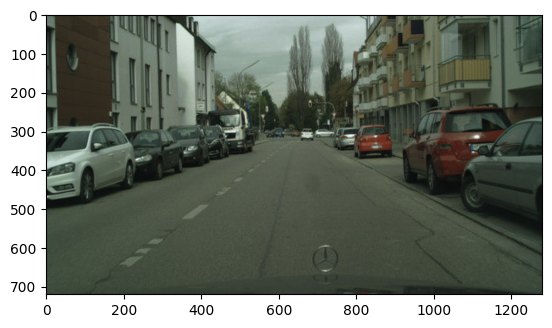

In [18]:
import requests

url = "https://cdn-media.huggingface.co/Inference-API/Sample-results-on-the-Cityscapes-dataset-The-above-images-show-how-our-method-can-handle.png"
cityscape_img = np.array(Image.open(requests.get(url, stream=True).raw).resize((1280, 720)))


plt.imshow(cityscape_img)
plt.show()

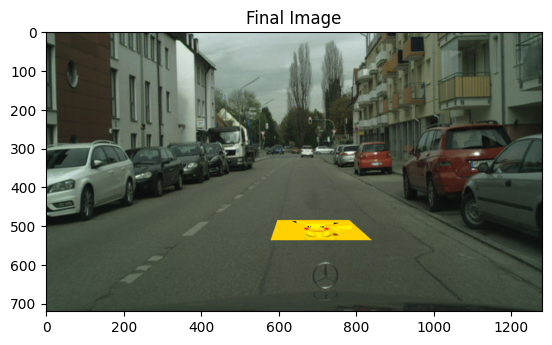

In [19]:
cityscape_img_torch = ToTensor()(cityscape_img)

# Apply the texture mask to the rendered image
final_image = projected_texture * texture_mask + cityscape_img_torch * (
    1.0 - texture_mask
)

# # Plot the final image
plt.figure()
plt.imshow(final_image.permute(1, 2, 0))
plt.title("Final Image")
plt.show()